In [1]:
!pip install finance-datareader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
from PIL import Image
import random

DAY_NUM = 32 # DAY_NUM거래일만큼의 차트 비교

In [4]:
def convert_image(data, num_images, day_num, name, code, save = False):

    def alpha_blend(color1, color2, alpha):
        return [
            int((color1[0] * alpha + color2[0] * (1 - alpha))),
            int((color1[1] * alpha + color2[1] * (1 - alpha))),
            int((color1[2] * alpha + color2[2] * (1 - alpha)))
        ]
    if len(data) < day_num + 20:
        print("종목 데이터 부족")
        return []

    if num_images > len(data) - day_num + 1 - 20:
        num_images = len(data) - day_num + 1 - 20


    return_datas = []
    image_idx = 1
    while(image_idx <= num_images):

        if image_idx != 1:
            stock_data = data[-image_idx - day_num + 1 : -image_idx + 1]
        else:
            stock_data = data[-day_num:]
        # 이미지 크기 설정
        width, height = day_num * 3, 96

        # High, Low, Close, Volume 데이터 정규화
        high_prices = stock_data['High'].values
        low_prices = stock_data['Low'].values
        open_prices = stock_data['Open'].values
        close_prices = stock_data['Close'].values

        high_prices_norm = (high_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        low_prices_norm = (low_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        open_prices_norm = (open_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        close_prices_norm = (close_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))

        if len(data) <= abs(-image_idx - day_num - 18):
            break

        # 이동평균선 추가를 위한 stock_data 생성
        if image_idx != 1:
            stock_data_ma20 = data[-image_idx - day_num - 18: -image_idx + 1]
        else:
            stock_data_ma20 = data[-image_idx - day_num - 18: ]

        stock_data_ma20 = stock_data_ma20.copy()
        stock_data_ma20['MA20'] = stock_data_ma20['Close'].rolling(window=20).mean()
        stock_data_ma20.dropna(inplace=True)

        # 이동평균선 값을 정규화
        stock_data_ma20['MA20_norm'] = (
                (stock_data_ma20['MA20'] - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
            )


        # 96x96 이미지 생성
        img = np.zeros((height, width, 3), dtype=np.uint8)  # 3 channels for RGB

        fail_generate = False
        for day in range(day_num):
            high_price = int(high_prices_norm[day] * (height - 1))
            low_price = int(low_prices_norm[day] * (height - 1))
            close_price = int(close_prices_norm[day] * (height - 1))
            open_price = int(open_prices_norm[day] * (height - 1))

            x_start = day * 3

            # 시가, 종가, 고가, 저가 막대그래프
            # 막대 왼쪽, 오른쪽 그리기 (시가, 종가 범위)
            for x in range(x_start, x_start + 3):
                if close_prices[day] > stock_data['Open'].values[day]:
                    color = [255, 0, 0]  # 상승: 빨강
                    tail_color = [200, 0, 0]  # 상승 시 꼬리: 어두운 빨강
                elif close_prices[day] < stock_data['Open'].values[day]:
                    color = [0, 0, 255]  # 하락: 파랑
                    tail_color = [0, 0, 200]  # 하락 시 꼬리: 어두운 파랑
                else: # 시가와 종가가 같을경우 어제보다 같거나 올랐으면 빨강, 아니면 파랑
                    if 0 <= stock_data['Change'].values[day]:
                        color = [255, 0, 0]  # 상승: 빨강
                        tail_color = [200, 0, 0]  # 상승 시 꼬리: 어두운 빨강
                    else:
                        color = [0, 0, 255]  # 하락: 파랑
                        tail_color = [0, 0, 200]  # 하락 시 꼬리: 어두운 파랑

                for y in range(min(open_price, close_price), max(open_price, close_price) + 1):
                    img[height - 1 - y, x] = color

            # 꼬리 그리기 (High, Low 범위)
            for x in range(x_start + 1, x_start + 2):
                for y in range(low_price, high_price + 1):
                    if img[height - 1 - y, x][0] != 255 and img[height - 1 - y, x][2] != 255:
                        img[height - 1 - y, x] = tail_color

            # 20일 이동평균선 그리기
            ma20_norm = stock_data_ma20.iloc[day]['MA20_norm']

            for x in range(x_start, x_start + 3):
                if not np.isnan(ma20_norm):
                    ma20_y = int(ma20_norm * (height - 1))
                    if 0 <= ma20_y < height:
                        for y in range(ma20_y - 1, ma20_y + 2):  # 이동평균선 주변에 블렌딩 처리
                            if 0 <= y < height:
                                new_color = alpha_blend([255, 255, 0], img[height - 1 - y, x], 0.4)  # 노란색으로 변경
                                img[height - 1 - y, x] = new_color

        #이미지가 day_num(그려지기 원하는 거래일 수)미만으로 그려졌으면
        if fail_generate:
            image_idx += 1
            continue

        if save :
            # 이미지 저장
            nimg = Image.fromarray(img, 'RGB')
            nimg.save(f'stock_data_image_{image_idx}.png')


        return_datas.append((img, name, code, stock_data.index[-1]))

        image_idx += 1


    return return_datas

In [5]:
def preprocess_data(data):
    # 0이나 NaN을 포함하는 행 제거
    data = data[data['Volume'] != 0]
    data = data.dropna(how='any')

    return data

In [6]:
class StockData:
    def __init__(self, open_prices, close_prices, high_prices, low_prices, max_volume_idx, name, code, date):
        self.open_prices = open_prices
        self.close_prices = close_prices
        self.high_prices = high_prices
        self.low_prices = low_prices
        self.max_volume_idx = max_volume_idx
        self.name = name
        self.code = code
        self.date = date

In [7]:
RIGHT_QUARTILE = 8 # 맨 마지막 종가를 몇분위로 나눌건지
LEFT_QUARTILE = 8

def convert_norm(data, num_images, day_num, name, code, save=False):
    global open_close_data

    if len(data) < day_num:
        print("종목 데이터 부족")
        if save:
            return 0
        else:
            return [[-1, -1, -1, -1, -1]]

    if num_images > len(data) - day_num + 1:
        num_images = len(data) - day_num + 1

    return_data = []
    image_idx = 1
    cnt = 0
    while(image_idx <= num_images):

        if image_idx != 1:
            stock_data = data[-image_idx - day_num + 1 : -image_idx + 1]
        else:
            stock_data = data[-day_num:]

        open_prices = stock_data['Open'].values
        close_prices = stock_data['Close'].values
        high_prices = stock_data['High'].values
        low_prices = stock_data['Low'].values

        highest_prices = high_prices.max()
        lowest_prices = low_prices.min()

        open_prices_norm = (open_prices - lowest_prices) / (highest_prices - lowest_prices)
        close_prices_norm = (close_prices - lowest_prices) / (highest_prices - lowest_prices)
        high_prices_norm = (high_prices - lowest_prices) / (highest_prices - lowest_prices)
        low_prices_norm = (low_prices - lowest_prices) / (highest_prices - lowest_prices)

        max_idx = day_num
        min_idx = day_num
        for i in range(day_num):
            if low_prices_norm[i] == 0:
                min_idx = i
            if high_prices_norm[i] == 1:
                max_idx = i


        first_close_idx = min(np.digitize(close_prices_norm[0], np.linspace(0, 1, LEFT_QUARTILE + 1)) - 1, LEFT_QUARTILE - 1)
        last_close_idx = min(np.digitize(close_prices_norm[-1], np.linspace(0, 1, RIGHT_QUARTILE + 1)) - 1, RIGHT_QUARTILE - 1)

        volume_data = stock_data['Volume'].values
        max_volume_idx = np.argmax(volume_data)

        image_idx += random.choice(range(1,4))
        cnt += 1

        if save:
            open_close_data[max_idx][last_close_idx][min_idx][first_close_idx].append(StockData(open_prices_norm, close_prices_norm, high_prices_norm, low_prices_norm, max_volume_idx, name, code, str(stock_data.index[-1])[:10]))
        else:
            return_data.append([max_idx, last_close_idx, min_idx, first_close_idx, StockData(open_prices_norm, close_prices_norm, high_prices_norm, low_prices_norm, max_volume_idx, name, code, str(stock_data.index[-1])[:10])])

    if save:
        return cnt
    else:
        return return_data

In [8]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/codes.csv', usecols=[0, 1], dtype={0: str})
# 첫 번째 열과 두 번째 열을 Nx2 리스트로 변환
stock_codes = df.values.tolist()

# 결과 출력
print(stock_codes)

[['095570', 'AJ네트웍스'], ['006840', 'AK홀딩스'], ['054620', 'APS'], ['265520', 'AP시스템'], ['211270', 'AP위성'], ['027410', 'BGF'], ['282330', 'BGF리테일'], ['126600', 'BGF에코머티리얼즈'], ['138930', 'BNK금융지주'], ['001460', 'BYC'], ['001465', 'BYC우'], ['013720', 'CBI'], ['083790', 'CG인바이츠'], ['001040', 'CJ'], ['079160', 'CJ CGV'], ['035760', 'CJ ENM'], ['311690', 'CJ 바이오사이언스'], ['00104K', 'CJ4우(전환)'], ['000120', 'CJ대한통운'], ['011150', 'CJ씨푸드'], ['011155', 'CJ씨푸드1우'], ['001045', 'CJ우'], ['097950', 'CJ제일제당'], ['097955', 'CJ제일제당 우'], ['051500', 'CJ프레시웨이'], ['058820', 'CMG제약'], ['023460', 'CNH'], ['056730', 'CNT85'], ['000480', 'CR홀딩스'], ['065770', 'CS'], ['083660', 'CSA 코스믹'], ['000590', 'CS홀딩스'], ['012030', 'DB'], ['404950', 'DB금융스팩10호'], ['456440', 'DB금융스팩11호'], ['367360', 'DB금융스팩9호'], ['016610', 'DB금융투자'], ['005830', 'DB손해보험'], ['000990', 'DB하이텍'], ['139130', 'DGB금융지주'], ['060900', 'DGP'], ['025440', 'DH오토웨어'], ['001530', 'DI동일'], ['000210', 'DL'], ['001880', 'DL건설'], ['000215', 'DL우'], ['375500', 'DL이앤씨'

In [9]:
open_close_data = [[[[[] for _ in range(LEFT_QUARTILE)] for _ in range(DAY_NUM)] for _ in range(RIGHT_QUARTILE)] for _ in range(DAY_NUM)]
def process():
    global open_close_data
    cnt_sum = 0
    for i, ticker in enumerate(stock_codes):
        code, name = ticker[0], ticker[1]
        print(f"{i+1}번째 종목 {name} 추출중...   ")

        try:
            stock_data = preprocess_data(fdr.DataReader(code, '2015-01-01'))  # 각 종목의 데이터 가져오기
            cnt = convert_norm(stock_data, 3000, DAY_NUM, name, code, save=True)
            cnt_sum += cnt
            print(f"{cnt}개 추출 / 총{cnt_sum}개")

        except IndexError:
            print(f"{name}에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.")
            continue

process()

1번째 종목 AJ네트웍스 추출중...   
989개 추출 / 총989개
2번째 종목 AK홀딩스 추출중...   
1053개 추출 / 총2042개
3번째 종목 APS 추출중...   
1024개 추출 / 총3066개
4번째 종목 AP시스템 추출중...   
789개 추출 / 총3855개
5번째 종목 AP위성 추출중...   
927개 추출 / 총4782개
6번째 종목 BGF 추출중...   
1068개 추출 / 총5850개
7번째 종목 BGF리테일 추출중...   
693개 추출 / 총6543개
8번째 종목 BGF에코머티리얼즈 추출중...   
1082개 추출 / 총7625개
9번째 종목 BNK금융지주 추출중...   
1067개 추출 / 총8692개
10번째 종목 BYC 추출중...   
1089개 추출 / 총9781개
11번째 종목 BYC우 추출중...   
1090개 추출 / 총10871개
12번째 종목 CBI 추출중...   
1022개 추출 / 총11893개
13번째 종목 CG인바이츠 추출중...   
1011개 추출 / 총12904개
14번째 종목 CJ 추출중...   
1051개 추출 / 총13955개
15번째 종목 CJ CGV 추출중...   
1048개 추출 / 총15003개
16번째 종목 CJ ENM 추출중...   
1051개 추출 / 총16054개
17번째 종목 CJ 바이오사이언스 추출중...   
447개 추출 / 총16501개
18번째 종목 CJ4우(전환) 추출중...   
492개 추출 / 총16993개
19번째 종목 CJ대한통운 추출중...   
1083개 추출 / 총18076개
20번째 종목 CJ씨푸드 추출중...   
1056개 추출 / 총19132개
21번째 종목 CJ씨푸드1우 추출중...   
1073개 추출 / 총20205개
22번째 종목 CJ우 추출중...   
1055개 추출 / 총21260개
23번째 종목 CJ제일제당 추출중...   
1052개 추출 / 총22312개
24번째 종목 CJ제일제당 우 추출중...   
1

<ipython-input-7-4dcf1a087aee>:37: RuntimeWarning: invalid value encountered in divide
  open_prices_norm = (open_prices - lowest_prices) / (highest_prices - lowest_prices)
<ipython-input-7-4dcf1a087aee>:38: RuntimeWarning: divide by zero encountered in divide
  close_prices_norm = (close_prices - lowest_prices) / (highest_prices - lowest_prices)
<ipython-input-7-4dcf1a087aee>:38: RuntimeWarning: invalid value encountered in divide
  close_prices_norm = (close_prices - lowest_prices) / (highest_prices - lowest_prices)
<ipython-input-7-4dcf1a087aee>:39: RuntimeWarning: invalid value encountered in divide
  high_prices_norm = (high_prices - lowest_prices) / (highest_prices - lowest_prices)
<ipython-input-7-4dcf1a087aee>:40: RuntimeWarning: invalid value encountered in divide
  low_prices_norm = (low_prices - lowest_prices) / (highest_prices - lowest_prices)


한국ANKOR유전에서 IndexError가 발생했습니다. 다음 종목으로 이동합니다.
2392번째 종목 한국가구 추출중...   
1032개 추출 / 총1996221개
2393번째 종목 한국가스공사 추출중...   
1059개 추출 / 총1997280개
2394번째 종목 한국경제TV 추출중...   
1058개 추출 / 총1998338개
2395번째 종목 한국공항 추출중...   
1037개 추출 / 총1999375개
2396번째 종목 한국금융지주 추출중...   
1015개 추출 / 총2000390개
2397번째 종목 한국금융지주우 추출중...   
1057개 추출 / 총2001447개
2398번째 종목 한국기업평가 추출중...   
1062개 추출 / 총2002509개
2399번째 종목 한국내화 추출중...   
1050개 추출 / 총2003559개
2400번째 종목 한국단자 추출중...   
1068개 추출 / 총2004627개
2401번째 종목 한국맥널티 추출중...   
929개 추출 / 총2005556개
2402번째 종목 한국무브넥스 추출중...   
1059개 추출 / 총2006615개
2403번째 종목 한국비엔씨 추출중...   
776개 추출 / 총2007391개
2404번째 종목 한국석유 추출중...   
1046개 추출 / 총2008437개
2405번째 종목 한국선재 추출중...   
1070개 추출 / 총2009507개
2406번째 종목 한국수출포장 추출중...   
1042개 추출 / 총2010549개
2407번째 종목 한국쉘석유 추출중...   
1067개 추출 / 총2011616개
2408번째 종목 한국알콜 추출중...   
1054개 추출 / 총2012670개
2409번째 종목 한국앤컴퍼니 추출중...   
1059개 추출 / 총2013729개
2410번째 종목 한국유니온제약 추출중...   
608개 추출 / 총2014337개
2411번째 종목 한국자산신탁 추출중...   
888개 추출 / 총2015225개
2412번째 종목 한국

In [9]:
import pickle

# with open("drive/MyDrive/Colab Notebooks/2015_hl.pkl", "wb") as f:
    # pickle.dump(open_close_data, f)

with open("drive/MyDrive/Colab Notebooks/2015_hl.pkl", "rb") as f:
    open_close_data = pickle.load(f)

In [10]:
 # Create a weight array that gives more weight to later elements
# WEIGHTS = np.linspace(1, 2, DAY_NUM) # 첫번째값1 에서 마지막값 2까지 선형적으로 증가

def rmse(predictions, targets, max_volume_idx):
    weights = np.linspace(1, 2, DAY_NUM)

    weights[max_volume_idx] *= 16 # 거래량이 제일 많은 날은 가중치 더 크게
    if max_volume_idx + 1 < DAY_NUM:
        weights[max_volume_idx+1] *= 4
    if max_volume_idx - 1 >= 0:
        weights[max_volume_idx-1] *= 2

    # Calculate the squared errors
    squared_errors = ((predictions - targets) ** 2)

    # Apply the weights to the squared errors
    weighted_squared_errors = weights * squared_errors

    # Calculate the mean and square root
    return np.sqrt(weighted_squared_errors.mean())

In [28]:
import numpy as np
import heapq

similar = {code : [] for code, name in stock_codes}  # 유사한 이미지들을 저장할 리스트

cnt = 0
for code, name in stock_codes[:1]:
    code = '001520'
    up, right, down, left, latest_data = convert_norm(preprocess_data(fdr.DataReader(code, '2023-03-01')), 1, DAY_NUM, name, code)[0]
    if up == -1:
        continue

    for u in range(max(up - 1, 0), min(up + 2, DAY_NUM)):
        for r in range(max(right - 1, 0), min(right + 2, RIGHT_QUARTILE)):
            for d in range(max(down - 1, 0), min(down + 2, DAY_NUM)):
                for l in range(max(left - 2, 0), min(left + 3, LEFT_QUARTILE)):
                    for data in open_close_data[u][r][d][l]:
                        dif = rmse(latest_data.open_prices, data.open_prices, latest_data.max_volume_idx) + rmse(latest_data.close_prices, data.close_prices, latest_data.max_volume_idx) + rmse(latest_data.high_prices, data.high_prices, latest_data.max_volume_idx) + rmse(latest_data.low_prices, data.low_prices, latest_data.max_volume_idx)
                        # (유사도 음수값, 데이터) 형태로 힙에 추가합니다.
                        heapq.heappush(similar[code], (-dif, data))

                        # similar 리스트의 크기가 100을 초과하면 가장 작은 원소(즉, 유사도가 가장 낮은 원소)를 제거합니다.
                        if len(similar[code]) > 20:
                            heapq.heappop(similar[code])

    similar[code].sort(reverse=True)

    cnt += 1
    print(cnt, name)

1 AJ네트웍스


In [30]:
from datetime import datetime, timedelta

similar_images = {code : [] for code, name in stock_codes}
for code, name in stock_codes[:1]:
    code = '001520'
    for dif, data in similar[code]:
        date_obj = datetime.strptime(data.date, '%Y-%m-%d')

        # 1년 이전의 날짜 계산
        one_year_ago = date_obj - timedelta(days=120)

        # 다시 문자열로 변환
        one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')
        stock_data = preprocess_data(fdr.DataReader(data.code, one_year_ago_str, data.date))  # 각 종목의 데이터 가져오기
        image = convert_image(stock_data, 1, DAY_NUM, data.name, data.code)
        if len(image) == 0:
            continue
        data.image = image[0][0]
        similar_images[code].append((dif, data))
        print(len(similar_images[code]))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
종목 데이터 부족
15
16
17
18
19


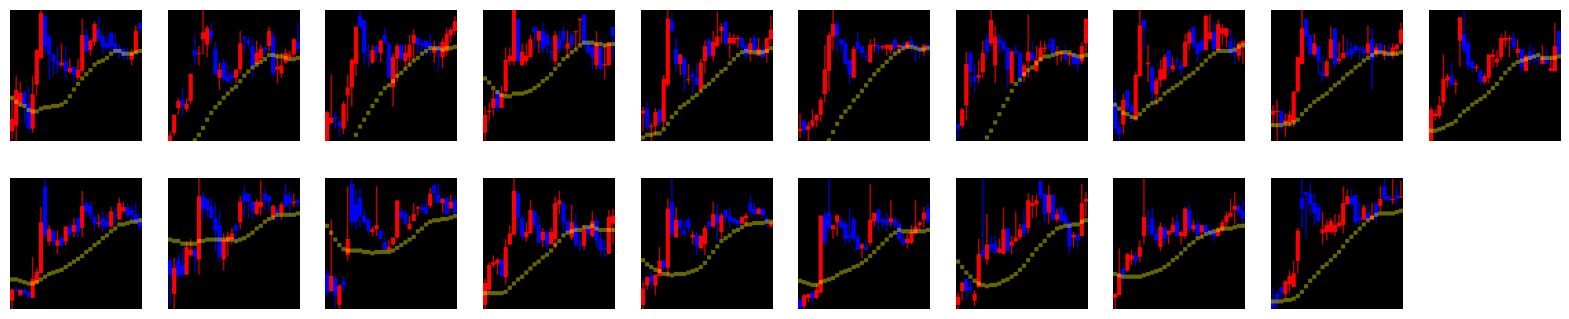

-0.0 동양 2023-09-15
-0.607298905420459 알에프세미 2023-05-26
-0.6725083293447809 서울가스 2023-02-24
-0.6733385178618568 현대지에프홀딩스 2019-07-17
-0.6747899187102948 에스제이그룹 2021-06-16
-0.6789564177615961 신한알파리츠 2019-10-11
-0.6807450112084867 대신정보통신 2020-05-21
-0.6808313286699189 CJ ENM 2016-03-16
-0.6826016569100938 삼호개발 2017-12-26
-0.6866799792691487 케이피티유 2015-12-28
-0.6896153734726527 홈센타홀딩스 2021-04-29
-0.6906815940572206 다스코 2015-10-08
-0.6925147479648558 에코플라스틱 2023-02-15
-0.6987627628197375 키네마스터 2019-07-19
-0.704382655262557 한국석유 2020-05-13
-0.708601724916117 에스퓨얼셀 2019-11-20
-0.7100711680613441 엑셈 2021-04-27
-0.7141836428049295 삼영엠텍 2021-04-21
-0.7150710122134859 세원정공 2019-02-27


In [31]:
import matplotlib.pyplot as plt
import math

code = '001520'
latest_image = convert_image(preprocess_data(fdr.DataReader(code, '2023-03-01')), 1, DAY_NUM, '삼성전자', '005930')[0][0]

# result.sort(reverse=True)
# 한 행에 표시될 서브플롯 수 (예: 4개)
cols = 10

# 필요한 행 수 계산
rows = math.ceil(len(similar_images[code]) / cols)

# 새로운 figure 생성
plt.figure(figsize=(20, rows * 2))

# 모든 유사한 이미지 출력
i = 0
for dif, data in similar_images[code]:
    plt.subplot(rows, cols, i+1)
    plt.imshow(data.image)
    plt.axis('off')  # 축 제거
    i += 1

plt.show()
for dif, data in similar_images[code][:20]:
    print(dif, data.name, data.date)